In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import numpy as np
import re

In [3]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

2025-04-02 12:00:41.882551: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 12:00:42.041880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743575442.103373   15943 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743575442.121619   15943 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743575442.241532   15943 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
df = pd.read_csv('processed_reddit_data.csv')

In [5]:
text = df[['proctext']].copy()

In [29]:
def sentiment_score(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():  
        output = model(**tokens)
    scores = torch.nn.functional.softmax(output.logits, dim=-1)
    
    sentiment = torch.argmax(scores, dim=-1).item() + 1  
    return sentiment  

In [30]:
df['proctext'] = df['proctext'].astype(str) 

In [31]:
df['sentiment_score'] = df['proctext'].apply(sentiment_score)

In [32]:
def label_sentiment(score):
    if score in [1, 2]:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

In [33]:
df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)

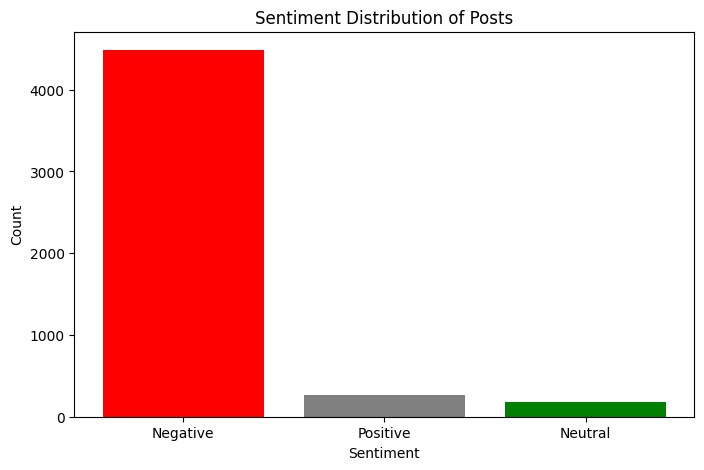

sentiment_label
Negative    4484
Positive     270
Neutral      174
Name: count, dtype: int64


In [35]:
import matplotlib.pyplot as plt

sentiment_counts = df['sentiment_label'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'gray', 'green'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution of Posts")
plt.show()

print(sentiment_counts)

In [36]:
print(df[['proctext', 'sentiment_label']])

                                               proctext sentiment_label
0     24m deal toxic shame thing past let hinder asp...        Negative
1     life everyon hate one cere act like think kill...        Negative
2     know go late depress mani year feel like okay ...        Negative
3     lost close friend know long stori short 18 rec...        Negative
4     sensat give want end back laid countless night...        Negative
...                                                 ...             ...
4923  know anyth diagnos say symptom make sad say ``...        Negative
4924  spent good month depress want anyth stay aslee...        Negative
4925  dissoci ident disord realiz need alter got kno...        Negative
4926  psych hospit lot time last year job right live...        Negative
4927  came today thing want get chest sure social an...        Negative

[4928 rows x 2 columns]


In [2]:
# pos_samples = df[df['sentiment_label'] == "Positive"].sample(10, random_state=42)
# neg_samples = df[df['sentiment_label'] == "Negative"].sample(10, random_state=42)
# neu_samples = df[df['sentiment_label'] == "Neutral"].sample(10, random_state=42)

# print("10 Positive Posts:")
# print(pos_samples[['proctext', 'sentiment_label']])
# print("\n10 Negative Posts:")
# print(neg_samples[['proctext', 'sentiment_label']])
# print("\n10 Neutral Posts:")
# print(neu_samples[['proctext', 'sentiment_label']])

In [5]:
from textblob import TextBlob
import pandas as pd

df = pd.read_csv("processed_reddit_data.csv")

df['proctext'] = df['proctext'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
df['proctext'] = df['proctext'].fillna("").astype(str)
df['sentiment'] = df['proctext'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['sentiment_label'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0.5 else 'Negative' if x < 0 else 'Neutral')

print(df[['proctext', 'sentiment', 'sentiment_label']].head(10))

                                            proctext  sentiment  \
0  24m deal toxic shame thing past let hinder asp...  -0.133333   
1  life everyon hate one cere act like think kill...  -0.300000   
2  know go late depress mani year feel like okay ...  -0.094600   
3  lost close friend know long stori short 18 rec...   0.137879   
4  sensat give want end back laid countless night...  -0.325000   
5  hi guy european guy studi unit state never rea...  -0.058730   
6  kind cri help life struggl depress anxieti hit...   0.078452   
7  god tir whatev father say neg suffer grandma '...  -0.054315   
8  depress hit realli hard insecur neg self talk ...  -0.005556   
9  16yr old like peopl nice life nice grade frien...  -0.091667   

  sentiment_label  
0        Negative  
1        Negative  
2        Negative  
3         Neutral  
4        Negative  
5        Negative  
6         Neutral  
7        Negative  
8        Negative  
9        Negative  


In [6]:
sentiment_counts = df['sentiment_label'].value_counts()
print(sentiment_counts)

sentiment_label
Neutral     2867
Negative    2019
Positive      42
Name: count, dtype: int64
